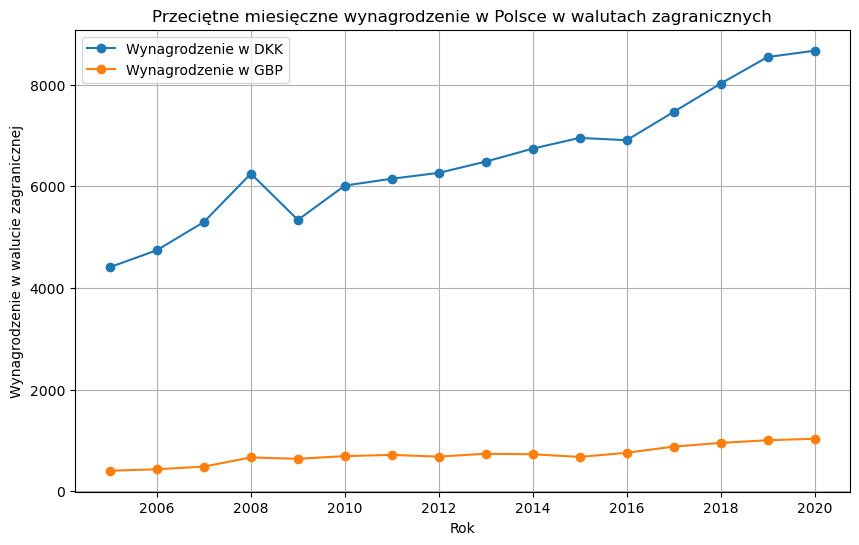

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from io import BytesIO

def pobierz_kursy_i_wynagrodzenia_wizualizuj(waluty, data_poczatkowa, data_koncowa, rozmiar_chunku=365, url_wynagrodzen="https://api.dane.gov.pl/media/resources/20221109/Przeci%C4%99tne_miesi%C4%99czne_wynagrodzenie_w_gospodarce_narodowej_w_latach_1950-2021.xlsx"):
    """
    Funkcja pobiera kursy wymiany walut z API NBP oraz dane o wynagrodzeniach z API, przetwarza je i wizualizuje wynagrodzenia w walutach zagranicznych.
    :param waluty: Lista kodów walut (np. ['dkk', 'gbp'])
    :param data_poczatkowa: Data początkowa (YYYY-MM-DD)
    :param data_koncowa: Data końcowa (YYYY-MM-DD)
    :param rozmiar_chunku: Liczba dni na chunk (domyślnie: 365)
    :param url_wynagrodzen: URL do pliku z danymi o wynagrodzeniach
    """
    def pobierz_kursy_w_chunkach(waluta, data_poczatkowa, data_koncowa, rozmiar_chunku):
        """
        Funkcja pobiera kursy wymiany walut z API NBP w chunkach o określonej wielkości.
        :param waluta: Kod waluty (np. 'dkk', 'gbp')
        :param data_poczatkowa: Data początkowa (YYYY-MM-DD)
        :param data_koncowa: Data końcowa (YYYY-MM-DD)
        :param rozmiar_chunku: Liczba dni na chunk (domyślnie: 365)
        :return: DataFrame z kursami wymiany
        """
        data_poczatkowa = datetime.strptime(data_poczatkowa, "%Y-%m-%d")
        data_koncowa = datetime.strptime(data_koncowa, "%Y-%m-%d")
        wszystkie_kursy = pd.DataFrame()

        aktualna_data_poczatkowa = data_poczatkowa
        while aktualna_data_poczatkowa <= data_koncowa:
            aktualna_data_koncowa = min(aktualna_data_poczatkowa + timedelta(days=rozmiar_chunku - 1), data_koncowa)
            url = f"https://api.nbp.pl/api/exchangerates/rates/a/{waluta}/{aktualna_data_poczatkowa.strftime('%Y-%m-%d')}/{aktualna_data_koncowa.strftime('%Y-%m-%d')}/?format=json"
            odpowiedz = requests.get(url)
            if odpowiedz.status_code == 200:
                dane = odpowiedz.json()
                kursy = [{"data": pozycja["effectiveDate"], "kurs": pozycja["mid"]} for pozycja in dane["rates"]]
                chunk_df = pd.DataFrame(kursy)
                wszystkie_kursy = pd.concat([wszystkie_kursy, chunk_df], ignore_index=True)
            else:
                print(f"Nie udało się pobrać danych od {aktualna_data_poczatkowa.strftime('%Y-%m-%d')} do {aktualna_data_koncowa.strftime('%Y-%m-%d')}: {odpowiedz.status_code}")

            aktualna_data_poczatkowa = aktualna_data_koncowa + timedelta(days=1)

        return wszystkie_kursy

    # Pobieranie kursów wymiany i zapisywanie
    kursy_walut = {}
    for waluta in waluty:
        kursy = pobierz_kursy_w_chunkach(waluta, data_poczatkowa, data_koncowa, rozmiar_chunku)
        kursy_walut[waluta] = kursy

    # Pobieranie danych o wynagrodzeniach z API
    response = requests.get(url_wynagrodzen)
    response.raise_for_status()
    dane_wynagrodzen = pd.ExcelFile(BytesIO(response.content)).parse(sheet_name=0)
    dane_wynagrodzen.columns = ["Przeciętne_miesięczne_wynagrodzenie", "Wartość_w_zł"]
    dane_wynagrodzen = dane_wynagrodzen.dropna(subset=["Wartość_w_zł"])
    dane_wynagrodzen = dane_wynagrodzen[dane_wynagrodzen["Przeciętne_miesięczne_wynagrodzenie"] != "Rok"]
    dane_wynagrodzen["Przeciętne_miesięczne_wynagrodzenie"] = dane_wynagrodzen["Przeciętne_miesięczne_wynagrodzenie"].astype(int)
    dane_wynagrodzen["Wartość_w_zł"] = dane_wynagrodzen["Wartość_w_zł"].astype(str).str.replace(',', '.').astype(float)
    dane_wynagrodzen = dane_wynagrodzen.rename(columns={"Przeciętne_miesięczne_wynagrodzenie": "Rok", "Wartość_w_zł": "Miesięczne_Wynagrodzenie_PLN"})
    dane_wynagrodzen = dane_wynagrodzen[(dane_wynagrodzen["Rok"] >= int(data_poczatkowa[:4])) & (dane_wynagrodzen["Rok"] <= int(data_koncowa[:4]))]

    # Obliczanie wynagrodzeń w walutach zagranicznych i wizualizacja
    plt.figure(figsize=(10, 6))
    for waluta, kursy in kursy_walut.items():
        kursy['data'] = pd.to_datetime(kursy['data'])
        kursy['Rok'] = kursy['data'].dt.year
        kursy_roczne = kursy.groupby('Rok')['kurs'].mean().reset_index()
        dane_polaczone = pd.merge(dane_wynagrodzen, kursy_roczne, on='Rok', how='inner')
        dane_polaczone[f'Miesięczne_Wynagrodzenie_{waluta.upper()}'] = dane_polaczone['Miesięczne_Wynagrodzenie_PLN'] / dane_polaczone['kurs']
        plt.plot(dane_polaczone['Rok'], dane_polaczone[f'Miesięczne_Wynagrodzenie_{waluta.upper()}'], label=f'Wynagrodzenie w {waluta.upper()}', marker='o')

    plt.title('Przeciętne miesięczne wynagrodzenie w Polsce w walutach zagranicznych')
    plt.xlabel('Rok')
    plt.ylabel('Wynagrodzenie w walucie zagranicznej')
    plt.legend()
    plt.grid(True)
    plt.show()

# Przykład użycia
pobierz_kursy_i_wynagrodzenia_wizualizuj(["dkk", "gbp"], "2005-01-01", "2021-12-31")
